In [6]:
import torch
import torch.nn as nn

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define CNN layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, 2)  # Output layer (2 classes: human speech, non-human speech)

    def forward(self, x):
        # Apply convolutional layers followed by ReLU activation and max pooling
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))

        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(-1, 64 * 32 * 32)

        # Fully connected layers with ReLU activation
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
import torch
# Initialize the model class
model = CNN()

# Load the state_dict into the model
model.load_state_dict(torch.load("cnn_weights.pth"))

# Access the convolutional layer
conv1_weights = model.conv1.weight.data
conv2_weights = model.conv2.weight.data

<ipython-input-9-f70a45877cf8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_weights.pth"))


In [10]:
import numpy as np

def normalize_kernel(kernel):
    if isinstance(kernel, torch.Tensor):  # Check if kernel is a PyTorch tensor
        kernel = kernel.cpu().numpy()  # Move to CPU and convert to NumPy array

    # Now kernel is a NumPy array, we can safely apply normalization
    kernel_min, kernel_max = kernel.min(), kernel.max()
    return ((kernel - kernel_min) / (kernel_max - kernel_min) * 255).astype(np.uint8)

We should expect 32 filters in the first layer and then 64 kernels in the next layer.

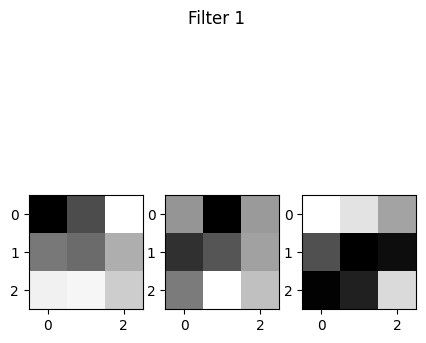

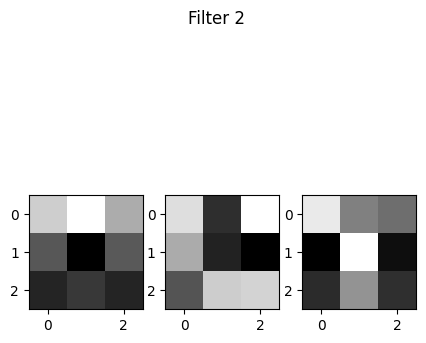

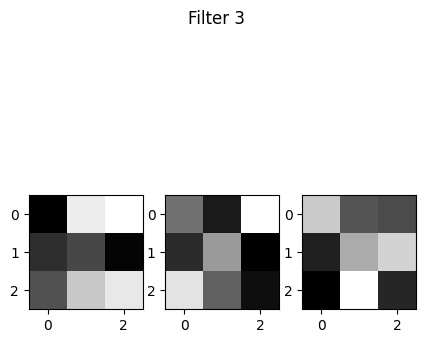

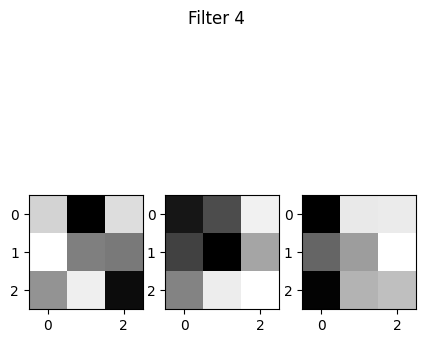

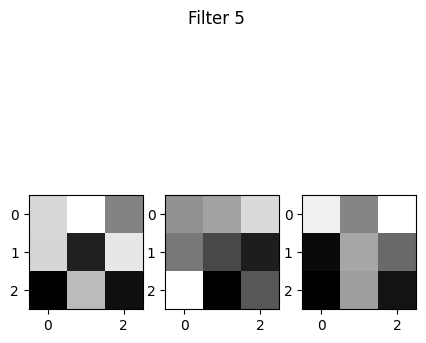

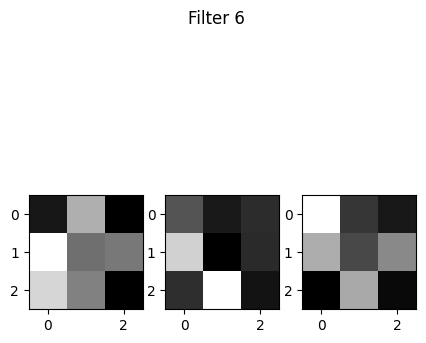

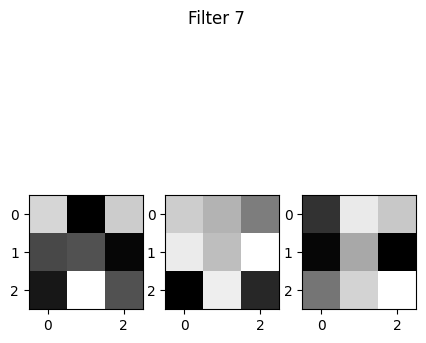

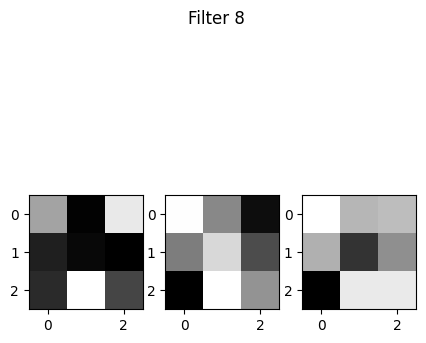

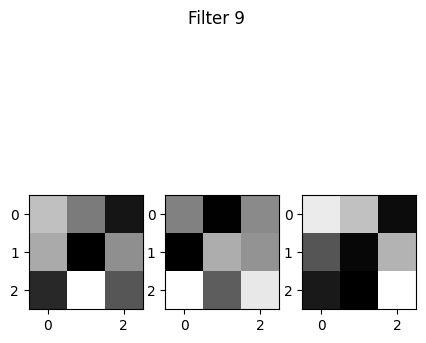

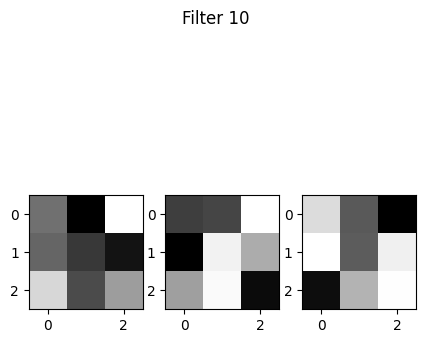

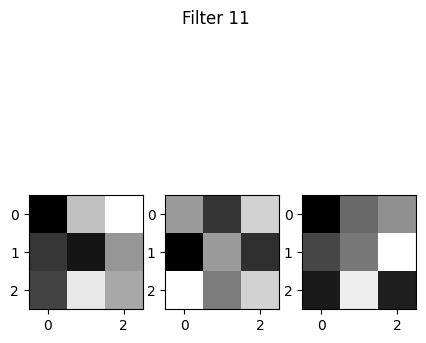

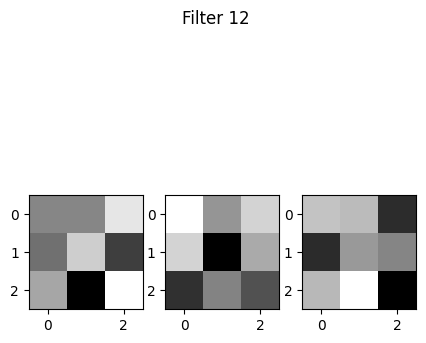

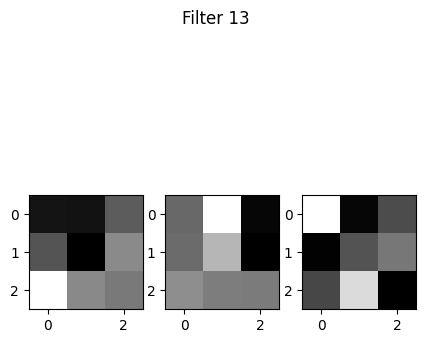

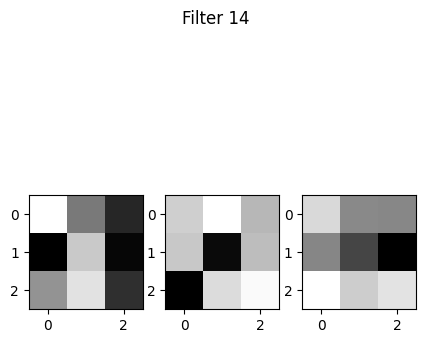

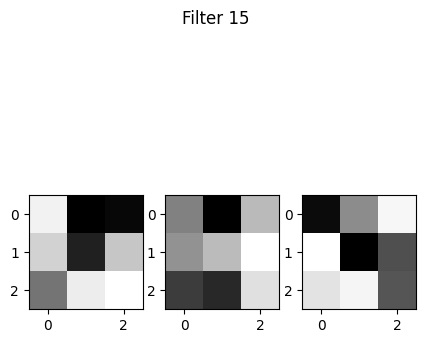

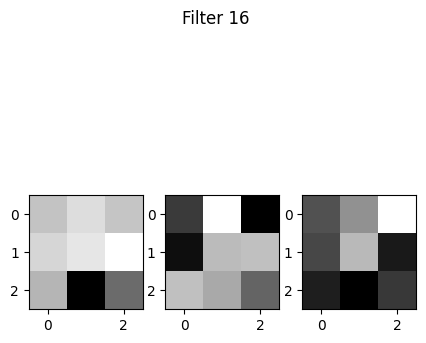

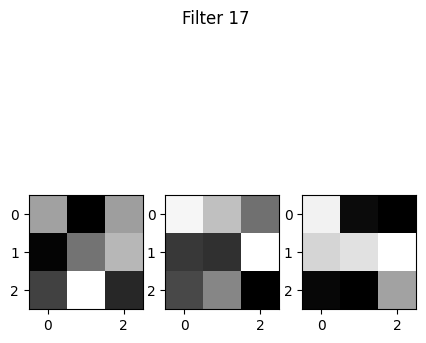

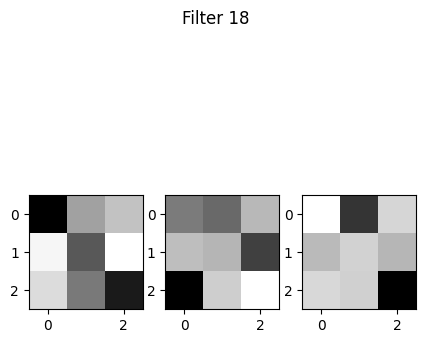

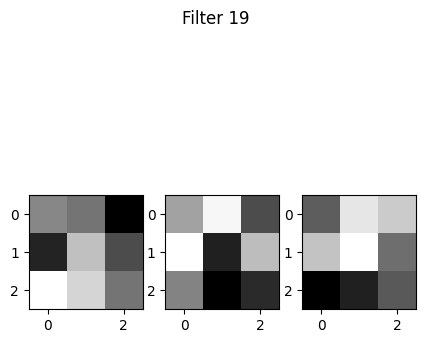

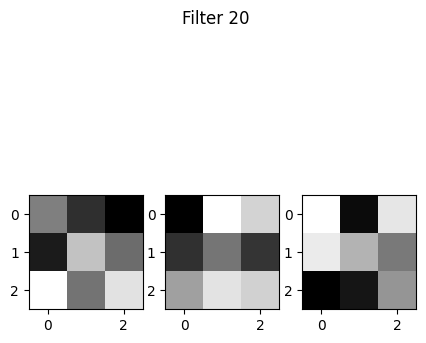

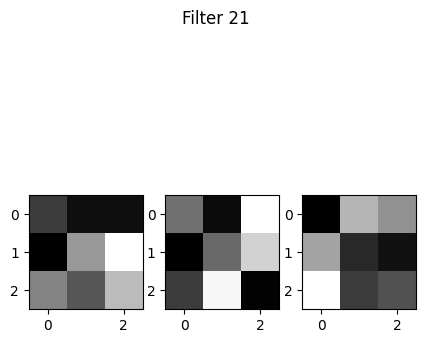

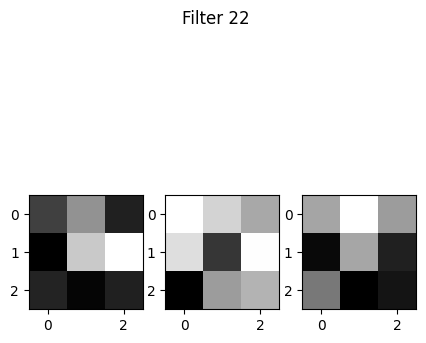

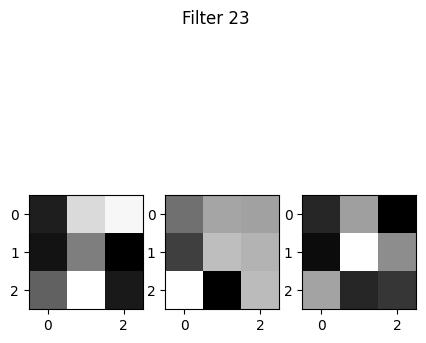

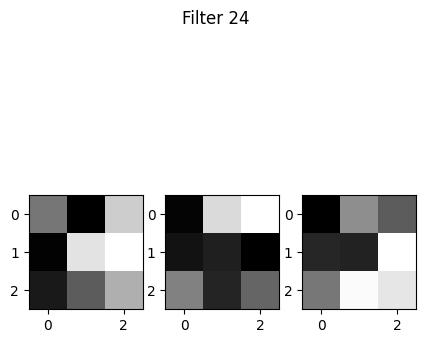

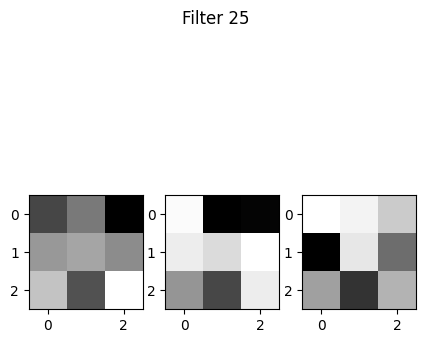

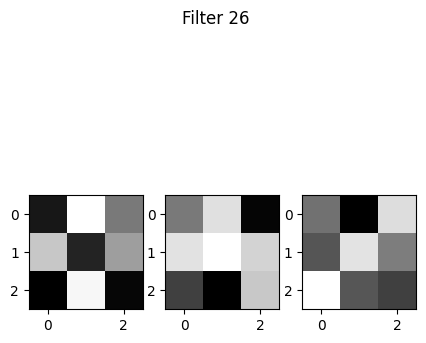

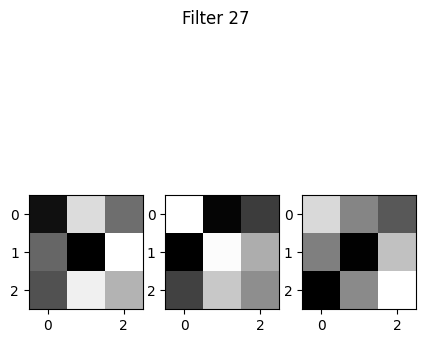

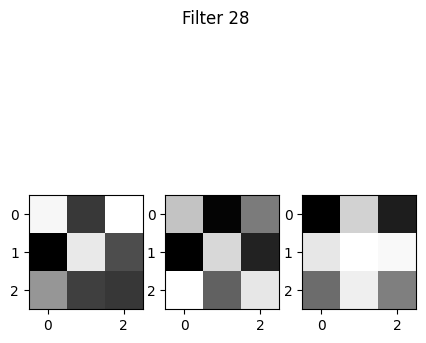

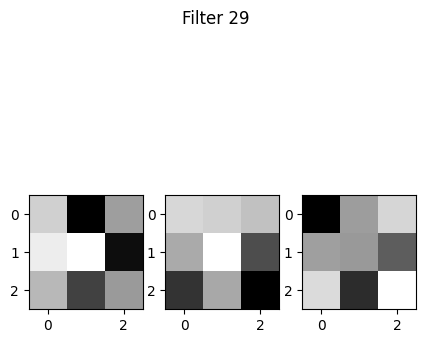

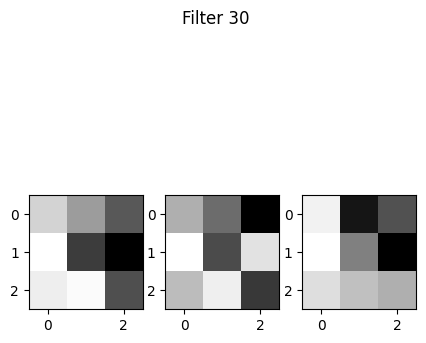

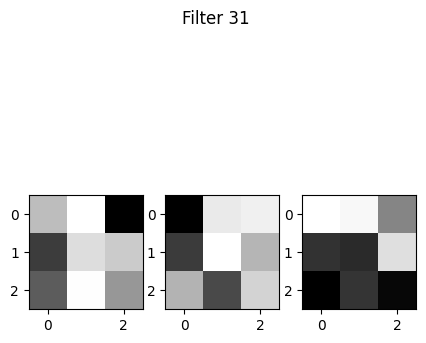

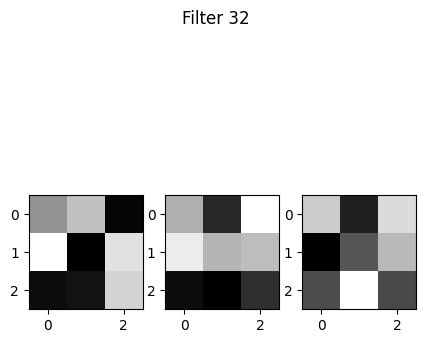

In [12]:
import matplotlib.pyplot as plt

def visualize_kernels(kernels):
    n_filters = kernels.shape[0]  # Number of filters
    n_channels = kernels.shape[1]  # Number of input channels

    # Create subplots for each filter
    for i in range(n_filters):
        plt.figure(figsize=(5, 5))
        plt.suptitle(f'Filter {i + 1}')
        for j in range(n_channels):
            plt.subplot(1, n_channels, j + 1)
            plt.imshow(normalize_kernel(kernels[i, j]), cmap='gray')
        plt.show()

# PyTorch example
kernels = conv1_weights.cpu().numpy()  # Convert to NumPy
visualize_kernels(kernels)

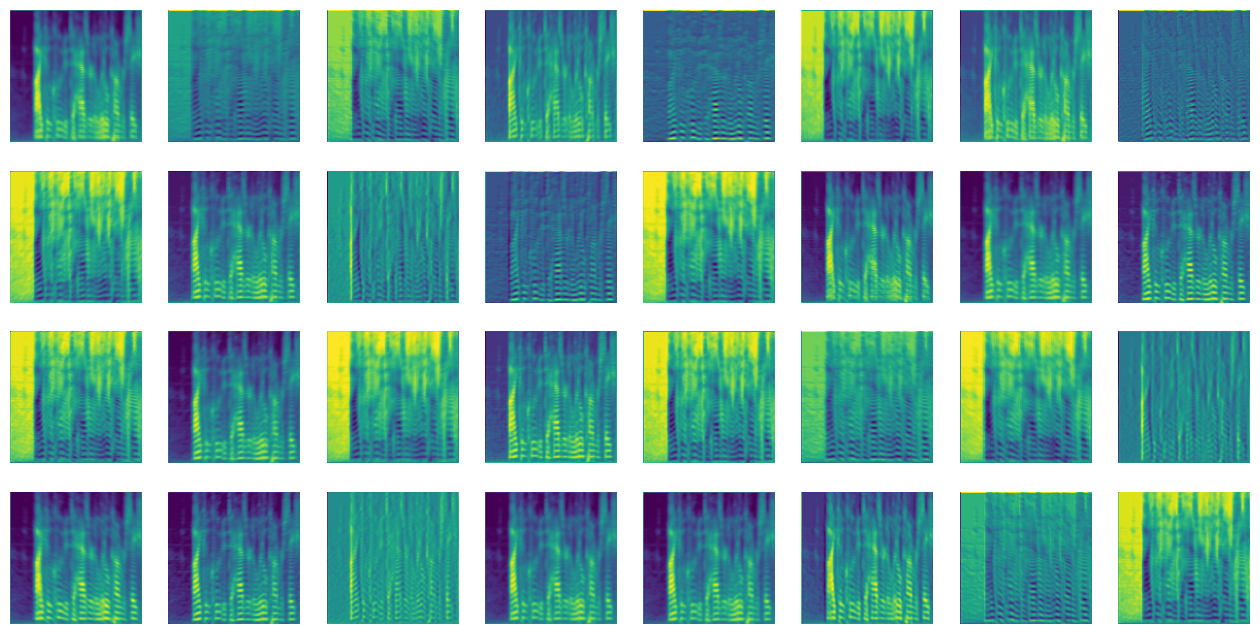

In [21]:
from torchvision import transforms
from PIL import Image

# Preprocess an input image
transform = transforms.Compose([
    transforms.Resize((128, 128)),        # Resize images to a fixed size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


img = Image.open("human.png")  # Replace with your image path
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Forward pass through the first convolutional layer
with torch.no_grad():
    feature_maps_conv1 = model.conv1(input_tensor)
    feature_maps_conv2 = model.conv2(model.pool(torch.relu(feature_maps_conv1)))

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, n_cols=8):
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension
    n_maps = feature_maps.shape[0]
    n_rows = (n_maps + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < n_maps:
            feature_map = feature_maps[i].cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
    plt.show()

# Visualize feature maps of the first and second convolutional layers
visualize_feature_maps(feature_maps_conv1)


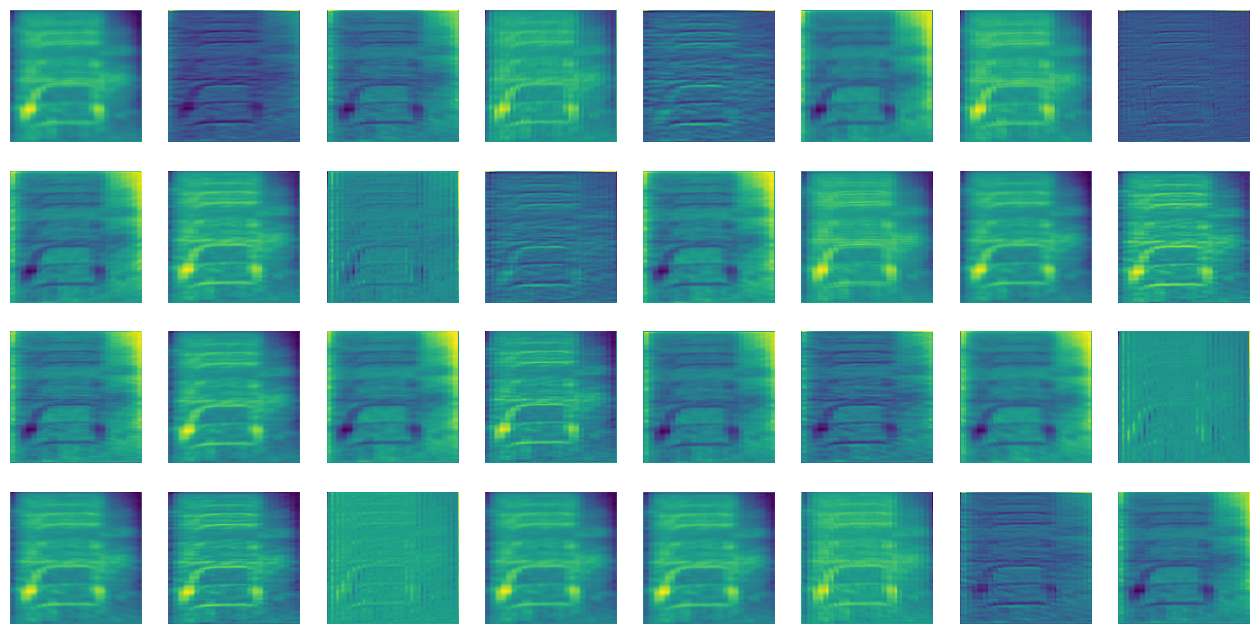

In [22]:
img = Image.open("non_human.png")  # Replace with your image path
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Forward pass through the first convolutional layer
with torch.no_grad():
    feature_maps_conv1 = model.conv1(input_tensor)
    feature_maps_conv2 = model.conv2(model.pool(torch.relu(feature_maps_conv1)))

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, n_cols=8):
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension
    n_maps = feature_maps.shape[0]
    n_rows = (n_maps + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < n_maps:
            feature_map = feature_maps[i].cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
    plt.show()

# Visualize feature maps of the first and second convolutional layers
visualize_feature_maps(feature_maps_conv1)
